## LSQ Spline

source: http://vadym-pasko.com/blog/2015/03/06/spline-approx-scipy.html <br>
& http://tsplb.blogspot.com/2015/03/approximation-by-spline-functions-and.html

In [15]:
#SQLite Db
import sqlite3
#dataframes
import pandas as pd

import numpy as np
#plots
import matplotlib.pyplot as plt
#lsq interpolation
import scipy.interpolate as si 

### Import the both datasets for turbine

In [9]:
%store -r df_hourly_1
%store -r df_hourly_2

df1=df_hourly_1[["Date","Time","plantno","power","wind","Median_power"]]
df2=df_hourly_2[["Date","Time","plantno","power","wind","Median_power"]]

In [10]:
#View tables
print("\033[1m"+"Turbine - Plant no.1"+"\033[0m")
print(df1)

print("\n")

print("\033[1m"+"Turbine - Plant no.2"+"\033[0m")
print(df2)

Turbine - Plant no.1
              Date      Time  plantno   power  wind  Median_power
23147   2021-06-06  14:34:38        1     4.0   1.3          11.0
111081  2021-06-16  16:10:57        1    28.0   1.3          11.0
112025  2021-06-16  16:36:16        1    11.0   1.3          11.0
111079  2021-06-16  16:10:54        1    32.0   1.4          19.5
110997  2021-06-16  16:08:42        1     7.0   1.4          19.5
...            ...       ...      ...     ...   ...           ...
82579   2021-06-10  14:20:10        1  2366.0  15.1        2371.0
81517   2021-06-10  13:52:22        1  2371.0  15.1        2371.0
81981   2021-06-10  14:04:29        1  2393.0  15.1        2371.0
81515   2021-06-10  13:52:19        1  2380.0  15.3        2380.0
81979   2021-06-10  14:04:26        1  2372.0  15.5        2372.0

[51459 rows x 6 columns]


Turbine - Plant no.2
              Date      Time  plantno   power       wind  Median_power
119133  2021-06-17  11:24:49        2    29.0   1.400000          1

In [120]:
# evaluate control points 
def getControlPoints(knots, k):
    n = len(knots) - 1 - k
    cx = np.zeros(n)
    for i in range(n):
        tsum = 0
        for j in range(1, k+1):
            tsum += knots[i+j]
        cx[i] = float(tsum)/k
    return cx

cp = getControlPoints(knots_full, k)

In [130]:
#Turbine 1
x=df1["wind"].reset_index(drop=True)
y=df1["Median_power"].reset_index(drop=True)
wmin, wmax = min(x), max(x) 
pmin, pmax = min(y), max(y)


In [328]:
#Define some control points and set some variables:
n = len(x)
plotpoints = 100

#set spline degree and find knot vector:
k = 4

#Construct uniform knot vector:
knotspace = range(n)
knots = si.InterpolatedUnivariateSpline(knotspace, knotspace, k=k).get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))

#nknot - is the number of knots in the reduced knot vector (one without k repeating values at the endings).
nknot=5

knot_offset = (wmax - wmin)/(nknot + 1)
knots = np.linspace(knot_offset, wmax-knot_offset, nknot)

#define the vector of weights w in order to force our further approximations to pass close to the end points of the original data
wend = 4
num_points=len(x)
w = [wend] + [1]*(num_points-2) + [wend]

In [331]:
knots=[1.5,2,3,4,5,6,7,8,9,10,11,12,13]

In [332]:
#Instantiate LSQUnivariateSpline class using coordinates of the data points, the knot vector and the weight vector:
lsqspline = si.LSQUnivariateSpline(x, y, knots, k=k, w=w)

In [333]:
#Get full-length knot vector, spline coefficients and coordinates of control points along the x-axis:
knots = lsqspline.get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))
coeffs_p = lsqspline.get_coeffs()
coeffs_w = getControlPoints(knots_full, k)

In [334]:
nsample = 100
xP = np.linspace(x[0], x[len(x) - 1], nsample)
yP = lsqspline(xP)

In [335]:
#save interpolated data to a df
di = pd.DataFrame({'Windspeed': xP,'Power': yP})

di.head(10)

,Windspeed,Power
0,1.300000,10.964285
1,1.443434,17.291548
2,1.586869,0.938089
3,1.730303,0.195150
4,1.873737,4.803041
5,2.017172,9.087579
6,2.160606,11.973424
7,2.304040,14.331584
8,2.447475,16.936551
9,2.590909,20.337143


In [344]:
#To use interactive navigator (zoom/ pan etc.)
%matplotlib notebook

<IPython.core.display.Javascript object>


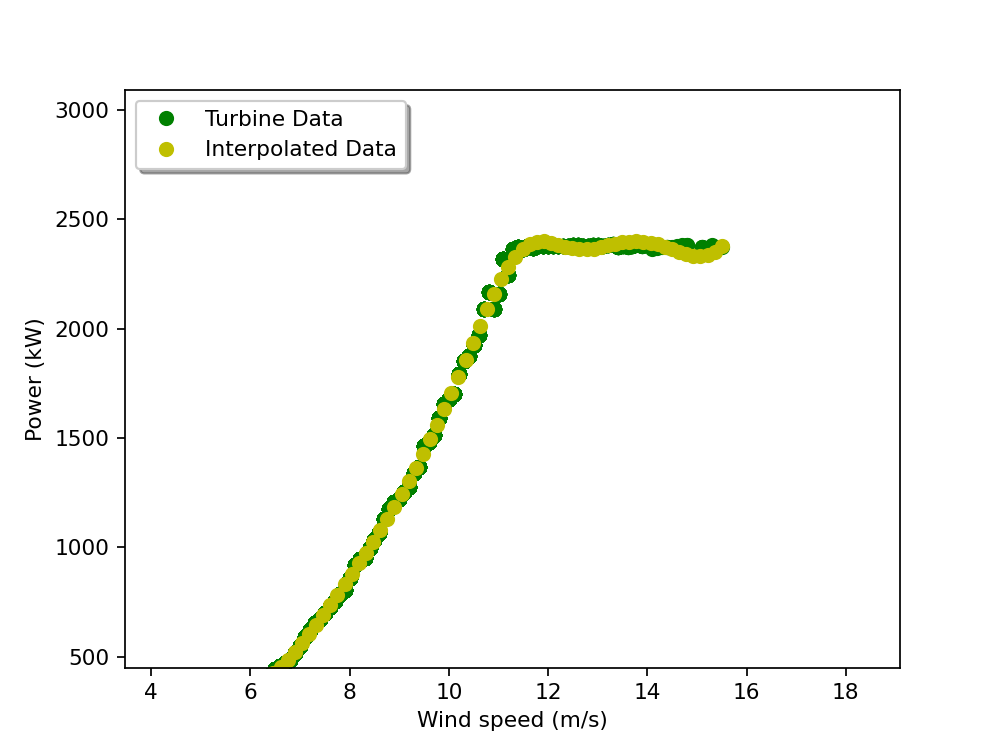

In [345]:
#plot results
fig, ax = plt.subplots()
ax.plot(x, y, 'go', label='Turbine Data')
ax.plot(xP, yP, 'yo', label='Interpolated Data')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
plt.ion()
plt.show()

## Apply interpolation for MetEirean Data

In [182]:
# import me data
%store -r me

In [183]:
me['windspeed'] = np.sqrt(me['u100wind'].pow(2) + me['v100wind'].pow(2))
#values greater than 1 for windspeed
me=me[(me.windspeed > 1.5) & (me.windspeed <15.5)]
me=me.sort_values(by=['windspeed'])
me.head(5)

,period,u100wind,v100wind,windspeed
61769,2021-05-28 12:00:00,0.536,-1.403,1.50190
62201,2021-05-28 12:00:00,0.536,-1.403,1.50190
61337,2021-05-28 12:00:00,0.536,-1.403,1.50190
62369,2021-05-29 12:00:00,1.472,-0.300,1.50226
62801,2021-05-29 12:00:00,1.472,-0.300,1.50226


In [210]:
w, p = di['Windspeed'].values, di['Power'].values

# Interpolate (w,p)
f = si.interp1d(w, p, kind='cubic')

# Apply interpolation curve to windspeed values in forecast to get power.
me['power'] = me['windspeed'].apply(f).round(3)

#round to 1 decimal to make a join later, with df1
me["windspeed"] = me["windspeed"].round(1)
me

,period,u100wind,v100wind,windspeed,power
61769,2021-05-28 12:00:00,0.536,-1.403,1.5,15.565
62201,2021-05-28 12:00:00,0.536,-1.403,1.5,15.565
61337,2021-05-28 12:00:00,0.536,-1.403,1.5,15.565
62369,2021-05-29 12:00:00,1.472,-0.300,1.5,15.565
62801,2021-05-29 12:00:00,1.472,-0.300,1.5,15.565
...,...,...,...,...,...
1839,2021-02-13 16:00:00,-4.023,14.963,15.5,2381.118
2531,2021-02-18 12:00:00,13.854,6.946,15.5,2381.118
13259,2021-03-10 00:00:00,11.359,10.544,15.5,2381.118
13475,2021-03-10 00:00:00,11.359,10.544,15.5,2381.118


### Compare ME interpolated values with Turbine data

Dataframes: <br>
me = data from MetEirean  <br>
df1 = data from Turbine/Plant No1  <br>
df2 = data from Turbine/Plant No2   <br>

In [208]:
data_check = pd.merge(me[["windspeed","power"]], df1[["power","wind","Median_power"]], left_on="windspeed",right_on="wind")
data_check.columns = ['WS_ME', 'Power_ME_Interpolated',"Power_turbine","Wind_turbine","Median_power_turbine"]
data_check

,WS_ME,Power_ME_Interpolated,Power_turbine,Wind_turbine,Median_power_turbine
0,1.5,15.081,5.0,1.5,5.0
1,1.5,15.081,4.0,1.5,5.0
2,1.5,15.081,6.0,1.5,5.0
3,1.5,15.081,5.0,1.5,5.0
4,1.5,15.081,4.0,1.5,5.0
...,...,...,...,...,...
7949342,15.5,2381.118,2372.0,15.5,2372.0
7949343,15.5,2381.118,2372.0,15.5,2372.0
7949344,15.5,2381.118,2372.0,15.5,2372.0
7949345,15.5,2381.118,2372.0,15.5,2372.0


In [209]:
#calculate the difference between ME power and Median power
data_check['diff'] = data_check['Power_ME_Interpolated'] - data_check['Median_power_turbine']
data_check

,WS_ME,Power_ME_Interpolated,Power_turbine,Wind_turbine,Median_power_turbine,diff
0,1.5,15.081,5.0,1.5,5.0,10.081
1,1.5,15.081,4.0,1.5,5.0,10.081
2,1.5,15.081,6.0,1.5,5.0,10.081
3,1.5,15.081,5.0,1.5,5.0,10.081
4,1.5,15.081,4.0,1.5,5.0,10.081
...,...,...,...,...,...,...
7949342,15.5,2381.118,2372.0,15.5,2372.0,9.118
7949343,15.5,2381.118,2372.0,15.5,2372.0,9.118
7949344,15.5,2381.118,2372.0,15.5,2372.0,9.118
7949345,15.5,2381.118,2372.0,15.5,2372.0,9.118


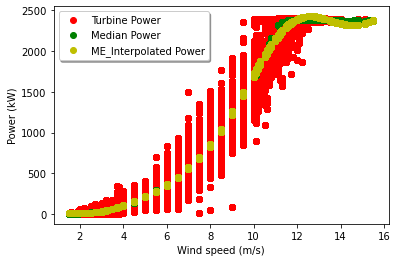

In [203]:
#plot results
fig, ax = plt.subplots()
ax.plot(data_check["Wind_turbine"], data_check["Power_turbine"], 'ro', label='Turbine Power')
ax.plot(data_check["Wind_turbine"], data_check["Median_power_turbine"], 'go', label='Median Power')
ax.plot(data_check["WS_ME"], data_check["Power_ME_Interpolated"], 'yo', label='ME_Interpolated Power')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
plt.show()